<a href="https://colab.research.google.com/github/rchicangana/AnalisisDatosProyecto/blob/IVAN/ProyectoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ESTADO DEL ARTE

- La imposibilidad de almacenar la energía eléctrica hace de la predicción una herramienta indispensable a la hora de gestionar eficientemente su producción. La modelización de la
demanda de energía eléctrica permite al ente productor contar con un conocimiento más refinado de los mercados y de los usuarios del sistema, así como con una mejor posición mediante la reducción de la incertidumbre en la toma de decisiones.  

- Se consultaron las Bases de Datos SciELO (Scientific Electronic Library Online) y RedAlyc (Red de Revistas Científicas de América Latina y el Caribe, España y Portugal), EBSCO, Springer Link, IEEE Xplorer y Google Académico.

- Para medir la relevancia y pertinencia de los documentos se tomaron como indicadores: que los artículos presentaran las técnicas utilizadas basadas en Inteligencia Artificial, así como metodologías y estudios de casos concretos dentro de las áreas que abarca la ingeniería eléctrica.

- Destacan dentro de las áreas de impacto la predicción de la producción y consumo eléctrico, lo cual se refiere a estudios realizados para establecer valores futuros del consumo eléctrico de una edificación particular, un complejo habitacional, industrial o incluso una ciudad o país completos. Como se indicó previamente, la adecuada predicción de estos datos es de gran importancia para planificar las fuentes de energía eléctrica y los costos asociados para los consumidores.

- La inteligencia artificial ofrece en la actualidad una diversidad de técnicas para la predicción de variables. Es la presencia de estas técnicas, en la forma de algoritmos implementados, que permiten relacionar las publicaciones con la inteligencia artificial. La diversidad de opciones de algoritmos generados se refleja en los artículos analizados
Las redes neuronales artificiales y las máquinas de vectores de soporte son las predominantes entre todas las utilizadas. Es importante destacar que es una práctica común la utilización de más de una técnica en un estudio de predicción, para realizar comparaciones y proponer la adopción de aquella técnica que haya dado mejores resultados. tambien se comentan tecnicas como Gradient Boosting y Modelos de Markov.

Entre las variables utilizadas para los analisis se encuentran principalmente la Temperatura, Humedad y la fecha de medicion


-Los resultados muestran una tendencia creciente en el interés de aprovechar las posibilidades de la inteligencia artificial a la tarea de predicción de variables, y confirman la mayor representatividad de los casos en la predicción de producción y consumo energético, y en variables relacionadas con energías renovables, tales como las condiciones del viento y de energía solar. La predominancia del idioma de las publicaciones es el inglés, y en países como China, Estados Unidos y Colombia es donde se ha dado la mayor cantidad de estudios.

-Los artículos más citados en la temática tratan sobre predicción de consumo eléctrico en edificaciones particulares, y de predicción de energía solar. Las predicciones son de utilidad para labores de planificación, estimación de costos y previsión de escenarios de inversión y aprovechamiento de recursos.

-El análisis realizado en el estado del arte deja patente la actualidad y necesidad del tema de inteligencia artificial para la ingeniería eléctrica, especialmente el conocimiento de las técnicas más utilizadas para los sistemas de predicción determinadas en el presente estudio, como lo son las redes neuronales artificiales, las máquinas de vectores de soporte y los árboles de decisión. Por otra parte, el creciente interés que muestran las referencias puede interpretarse como un área de oportunidad para aprovechar las ventajas de los estudios de predicción de variables con los nuevos métodos de inteligencia artificial en lugares donde aún no se han implementado.


## Articulos consultados

- https://www.sciencedirect.com/science/article/pii/S2352484724007315
- https://ciencialatina.org/index.php/cienciala/article/view/2502
- https://www.revistaespacios.com/a17v38n22/a17v38n21p03.pdf
- http://www.scielo.org.co/scielo.php?script=sci_arttext&pid=S1794-12372016000200009
- https://pmc.ncbi.nlm.nih.gov/articles/PMC10948898/
- https://www.redalyc.org/pdf/462/46247652001.pdf
- https://www.kaggle.com/datasets/fedesoriano/electric-power-consumption

### Los articulos mas citados en la publicaciones fueron


| Autores                                                       | Título del   artículo                                                                                                                                                                                        | Nombre de   la revista/publicación                           | Año  | Cantidad de citas |
|---------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------|------|-------------------|
| Gonzalez,   P. A., y Zamarreno, J. M..                        | Prediction of hourly energy   consumption in buildings based on a feedback artificial neural network                                                                                                         | Energy and buildings                                         | 2005 | 392               |
| Jain,   R. K., Smith, K. M., Culligan, P. J., y Taylor, J. E. | Forecasting energy consumption   of multi-family residential buildings using support vector regression:   Investigating the impact of temporal and spatial monitoring granularity on   performance accuracy. | Applied Energy                                               | 2014 | 379               |
| Sharma,   N., Sharma, P., Irwin, D., y Shenoy, P.             | Predicting solar generation from   weather forecasts using machine learning.                                                                                                                                 | IEEE international conference on   smart grid communications | 2011 | 370               |
| Yang,   J., Rivard, H., y Zmeureanu, R.                       | On-line building energy   prediction using adaptive artificial neural networks.                                                                                                                              | Energy and buildings,                                        | 2005 | 368               |
| Ekici,   B. B., y Aksoy, U. T.                                | Prediction of building energy   consumption by using artificial neural networks.                                                                                                                             | Advances in Engineering   Software.                          | 2009 | 358               |
| Mocanu,   E., Nguyen, P. H., Gibescu, M., y Kling, W. L.      | Deep learning for estimating   building energy consumption.                                                                                                                                                  | Sustainable Energy, Grids and   Networks.                    | 2016 | 342               |
| Edwards,   R. E., New, J., y Parker, L. E.                    | Predicting future hourly   residential electrical consumption: A machine learning case study.                                                                                                                | Energy and Buildings.                                        | 2012 | 275               |
| Ahmad,   M. W., Mourshed, M., y Rezgui, Y.                    | Trees vs Neurons: Comparison   between random forest and ANN for high-resolution prediction of building   energy consumption.                                                                                | Energy and Buildings                                         | 2017 | 263               |
| Tüfekci,   P.                                                 | Prediction of full load   electrical power output of a base load operated combined cycle power plant   using machine learning methods.                                                                       | International Journal of   Electrical Power & Energy Systems | 2014 | 241               |
| Candanedo,   L. M., Feldheim, V., y Deramaix, D.              | Bélgica                                                                                                                                                                                                      | Energy and buildings                                         | 2017 | 2                 |




# 1  Introduccion

El análisis exploratorio de datos es una etapa fundamental en cualquier proyecto de Inteligencia Artificial y Ciencia de Datos, puesto que permite entender las características y patrones en los datos, así como identificar relaciones entre variables.

A continuación se presenta un estudio basado en datos de consumo de energía eléctrica horaria registrados en Cali, Colombia, junto con las temperaturas correspondientes a cada hora. El objetivo principal es explorar la relación entre estas dos variables y, posteriormente, aplicar diferentes modelos para realizar el pronósticos de corto plazo del demanda de energía.

# 2  Contexto

La demanda de energía eléctrica en una ciudad se ve inlfuenciada por muchos factores, como la temperatura, factores sociales, cronograma de produccion de grandes clientes, entre otros.

En regiones con climas variables, como es el caso de muchas ciudades Colombianas, la demanda es afectada por el uso intensivo de sistemas de refrigeración en épocas calurosas.

Los datos utilizados en este análisis incluyen mediciones horarias del consumo de energía y la temperatura registrada en la misma franja horaria, tipos de dia, mes y año. Lo que permite explorar la correlación entre estas variables.

Adicionalmente, se busca evaluar el desempeño de diferentes modelos como regresiones lineales, redes neuronales y modelos basados en árboles de decisión, para predecir el consumo de energía en un horizonte de corto plazo.

## 2.1  Descripción de los campos

- FECHA: Fecha en formato ISO de la lectura del consumo
- TEMPERATURA: Temperatura en grados Centigrados al momento de la toma del dato
- CONSUMO: Variable objetvio medido en MVA

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import holidays
import glob


df = pd.read_csv('Data/datasetEmcali.csv')



In [2]:
print("primeras filas \n")
print(df.head())


print("se describen las columnas \n")
print(df.info())

print("dimensiones \n")
print(df.shape)

primeras filas 

             FECHA  TEMPERATURA  CONSUMO
0  12/01/2017 0:00         27.9    409.0
1  12/01/2017 1:00         29.0    387.0
2  12/01/2017 2:00         29.1    378.0
3  12/01/2017 3:00         28.2    370.0
4  12/01/2017 4:00         26.7    364.0
se describen las columnas 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29808 entries, 0 to 29807
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FECHA        29808 non-null  object 
 1   TEMPERATURA  29616 non-null  float64
 2   CONSUMO      29520 non-null  float64
dtypes: float64(2), object(1)
memory usage: 698.8+ KB
None
dimensiones 

(29808, 3)


# 3  Análisis exploratorio


## 3.1  Análisis de estructura


Se realiza un analisis de la forma del dataset, se relacionan tipos de datos, estadisticas descriptivas y valores nulos.

Se adicionan columnas, basadas en la fecha, con la hipotesis que esto permitira al modelo entender e interpretar mejor los datos.

Tratamiento de dataset Humedad

In [3]:
#Defino el formato de la fecha
df["Date"] = pd.to_datetime(df["FECHA"], format="mixed", errors="coerce")

# Cargar datasets de humedad
humedad_files = glob.glob("Data/reporte_sisaire-humedad-*.csv")
df_humedad_list = [pd.read_csv(file) for file in humedad_files]
df_humedad = pd.concat(df_humedad_list)

# Convertir fechas en el dataset de humedad
df_humedad["Fecha inicial"] = pd.to_datetime(df_humedad["Fecha inicial"], format="%Y-%m-%d %H:%M")

# Promediar la humedad por hora
df_humedad_avg = df_humedad.groupby("Fecha inicial")["HAire2"].mean().reset_index()
df_humedad_avg.rename(columns={"Fecha inicial": "Date", "HAire2": "Humidity"}, inplace=True)

df_humedad_avg.head()

,Date,Humidity
0,2017-01-01 00:00:00,82.75
1,2017-01-01 01:00:00,83.05
2,2017-01-01 02:00:00,83.50
3,2017-01-01 03:00:00,84.95
4,2017-01-01 04:00:00,85.30


Tratamiento de dataset Temperatura

In [4]:
# Cargar datasets de velocidad del viento
viento_files = glob.glob("Data/reporte_sisaire-vViento-*.csv")
df_viento_list = [pd.read_csv(file) for file in viento_files]
df_viento = pd.concat(df_viento_list)

# Convertir fechas en el dataset de viento
df_viento["Fecha inicial"] = pd.to_datetime(df_viento["Fecha inicial"], format="%Y-%m-%d %H:%M")

# Promediar la velocidad del viento por hora
df_viento_avg = df_viento.groupby("Fecha inicial")["VViento"].mean().reset_index()
df_viento_avg.rename(columns={"Fecha inicial": "Date", "VViento": "Wind"}, inplace=True)

df_viento_avg.head()

,Date,Wind
0,2017-01-01 00:00:00,0.75
1,2017-01-01 01:00:00,0.70
2,2017-01-01 02:00:00,0.75
3,2017-01-01 03:00:00,0.80
4,2017-01-01 04:00:00,0.95


Unión de datos de dos DataFrames, df_humedad_avg y df_viento_avg, con el DataFrame principal df

In [5]:
df_humedad_avg["Date"] = pd.to_datetime(df_humedad_avg["Date"])
df_viento_avg["Date"] = pd.to_datetime(df_viento_avg["Date"])

df = df.merge(df_humedad_avg, on="Date", how="left", suffixes=("","_extra"))
df = df.merge(df_viento_avg, on="Date", how="left" , suffixes=("","_extra"))

Se realiza la Conversion de Columnas a Valores Numericos y se eliminnan las filas que tienen valores nulos en 'FECHA' y 'CONSUMO', 'TEMPERATURA', 'HUMEDAD', 'VIENTO'

In [7]:
df['Consumption'] = pd.to_numeric(df['CONSUMO'], errors='coerce')

df['Temperature'] = pd.to_numeric(df['TEMPERATURA'], errors='coerce')

df['Humidity'] = pd.to_numeric(df['Humidity'], errors='coerce')

df['Wind'] = pd.to_numeric(df['Wind'], errors='coerce')

# Elimino las filas que tienen valores nulos

df = df.dropna(subset=['Date', 'Consumption', 'Temperature', 'Humidity', 'Wind'])

Se Verifica si la fecha es un dia festivo en Colombia

In [8]:
def es_festivo_colombia(fecha):
    """Verifica si una fecha es festivo en Colombia."""
    co_holidays = holidays.CO(years=fecha.year)
    return fecha in co_holidays
df['Is_holiday'] = df['Date'].apply(es_festivo_colombia)

Se decompone la fecha, se crean nuevas columnas basados en sus componentes, Esto puede ser útil para análisis de series temporales o para extraer información adicional de las fechas.

In [9]:
# se descompone la fecha
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Hour'] = df['Date'].dt.hour
df['Dayofweek'] = df['Date'].dt.dayofweek
df['Dayofyear'] = df['Date'].dt.dayofyear
df['Weekofyear'] = df['Date'].dt.isocalendar().week
df['Is_month_end'] = df['Date'].dt.is_month_end
df['Is_month_start'] = df['Date'].dt.is_month_start
df['Is_quarter_end'] = df['Date'].dt.is_quarter_end
df['Is_quarter_start'] = df['Date'].dt.is_quarter_start
df['Is_year_end'] = df['Date'].dt.is_year_end
df['Is_year_start'] = df['Date'].dt.is_year_start

Se eliminan columnas innecesarias

In [10]:
# Eliminar la columna 'FECHA', ya que no es necesaria
df = df.drop('Date', axis=1)
df = df.drop('FECHA', axis=1)
df = df.drop('TEMPERATURA', axis=1)
df = df.drop('CONSUMO', axis=1)

In [11]:



# Convert categorical columns to categorical
categorical_cols = ['Year', 'Month', 'Day', 'Hour', 'Dayofweek', 'Dayofyear', 'Weekofyear']
for col in categorical_cols:
    df[col] = df[col].astype('category')

print("Forma de lo datos:", df.shape)
print("\nTipo de datos por columnas:\n\n", df.dtypes)
print("\nEstadisticas descriptivas:\n\n", df.describe())
print("\nValores Faltantes:\n\n", df.isnull().sum())
print("\nValores Faltantes(%):\n\n", (df.isnull().sum() / len(df)) * 100)

Forma de lo datos: (26168, 18)

Tipo de datos por columnas:

 Humidity             float64
Wind                 float64
Consumption          float64
Temperature          float64
Is_holiday              bool
Year                category
Month               category
Day                 category
Hour                category
Dayofweek           category
Dayofyear           category
Weekofyear          category
Is_month_end            bool
Is_month_start          bool
Is_quarter_end          bool
Is_quarter_start        bool
Is_year_end             bool
Is_year_start           bool
dtype: object

Estadisticas descriptivas:

            Humidity          Wind   Consumption   Temperature
count  26168.000000  26168.000000  26168.000000  26168.000000
mean      67.572628      2.056769    455.835792     24.166783
std       13.826779      1.381898     96.408024      3.205015
min       14.850000      0.100000    227.000000     16.100000
25%       56.010714      1.200000    371.000000     21.700000


se notan valores nulos

## 3.2  Análisis de variables numericas y continuas


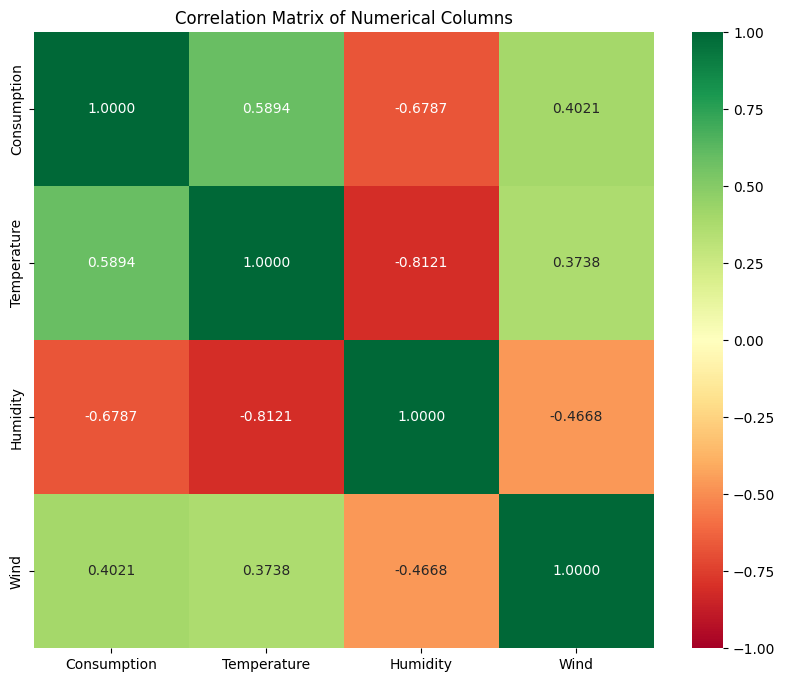

Correlation between Consumption and CONSUMO: 1.0000
Correlation between Temperature and CONSUMO: 0.5894
Correlation between Humidity and CONSUMO: -0.6787
Correlation between Wind and CONSUMO: 0.4021


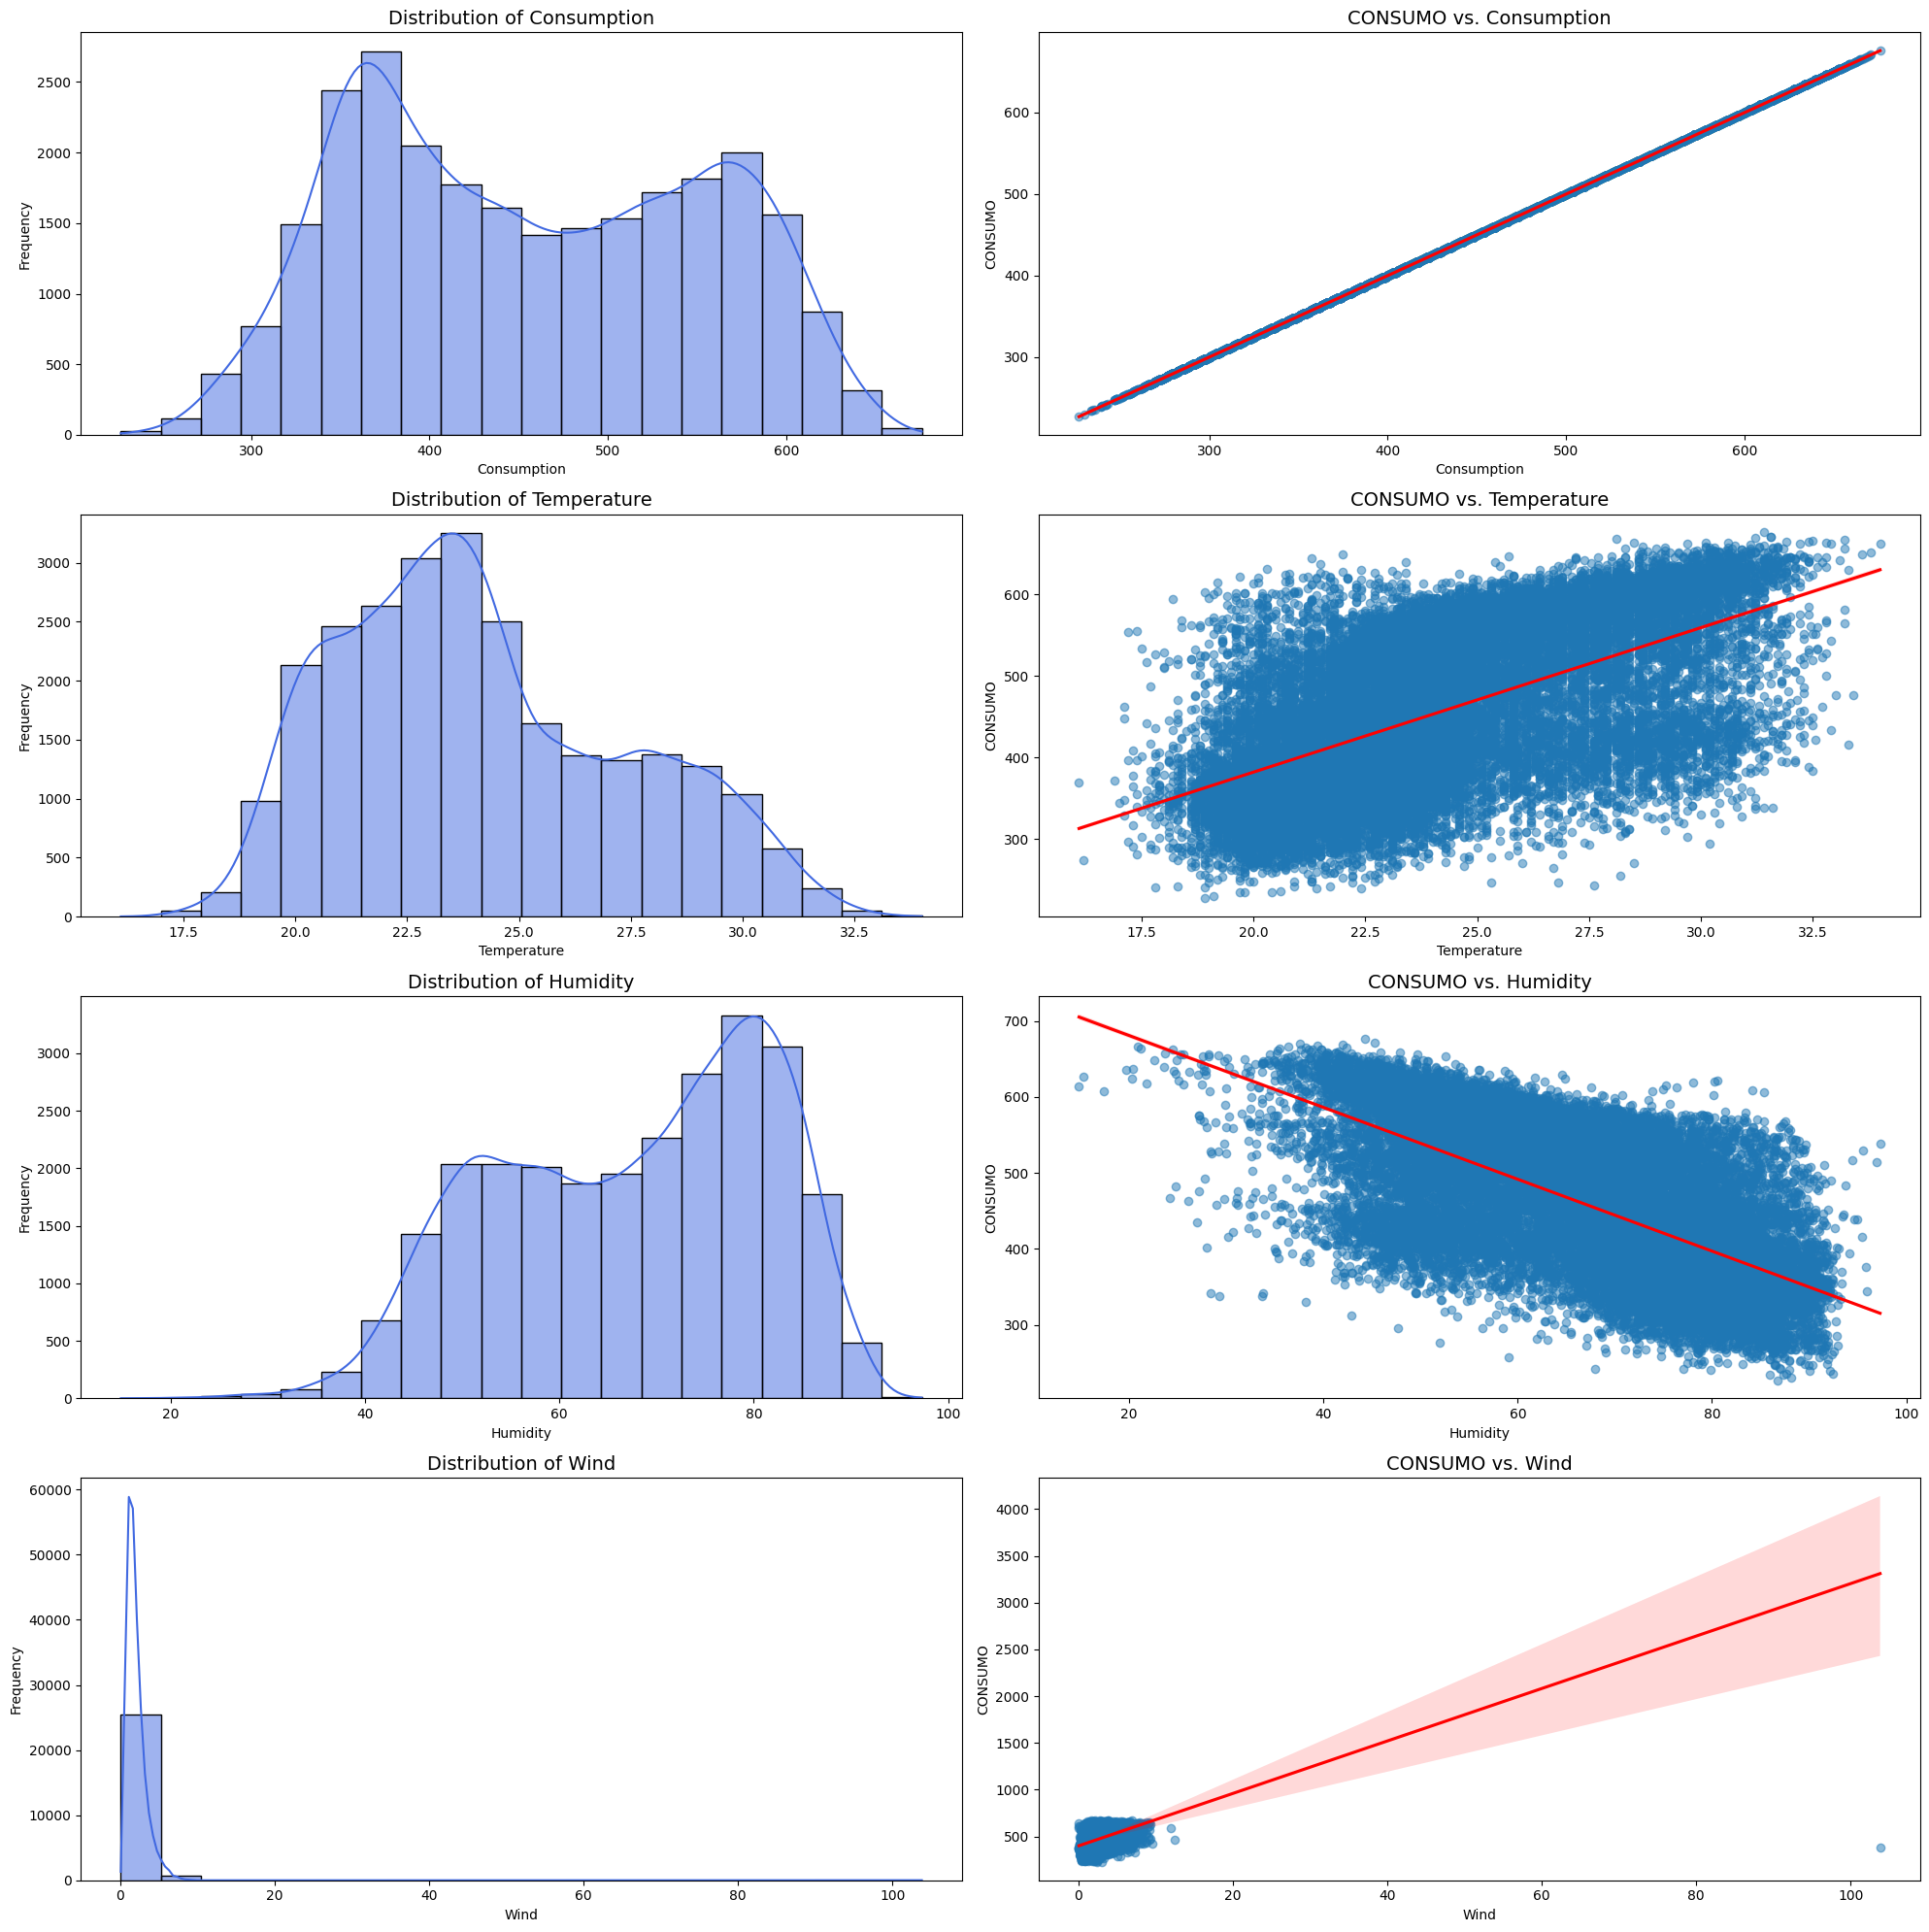

In [17]:

# Se define las columnas numericas a analizar
numerical_columns = ['Consumption', 'Temperature', 'Humidity', 'Wind']

# PRIMERO => Matriz de Correlacion
# Se calcula la matriz de correlacion entre ellas
correlation_matrix = df[numerical_columns].corr()

# Configuracion del grafico para la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True, #Muestra los valores de correlacion
    cmap='RdYlGn', #Paleta de Colores(rojo-amarrillo-verde)
    fmt='0.4f', #Formato de 4 decimales
    vmin=-1, vmax=1, #Rango de valores para la escala de colores
)
plt.title('Correlation Matrix of Numerical Columns')
plt.show()
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# SEGUNDO => Analisis de Distribucion y Relacion con Consumo
# Se configura el diselo de subplots
num_cols = 2 # Numero de columnas por fila
num_rows = (len(numerical_columns)) # Una fila por variable

# Crear la figura y los subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
axes = axes.flatten() # Convertir la matriz de subplots en una lista plana

# Iteracion sobre cada columna numérica
for i, col in enumerate(numerical_columns):
    # Histograma: Distribucion de la variable
    sns.histplot(df[col], bins=20, kde=True, ax=axes[i * 2], color='royalblue') # KDE para visualizar la distribución
    axes[i * 2].set_title(f'Distribution of {col}', fontsize=14)
    axes[i * 2].set_xlabel(col)
    axes[i * 2].set_ylabel('Frequency')
    
    # Grafico de disperson: Relacion con CONSUMO
    sns.regplot(
        x=col,
        y='Consumption',
        data=df,
        ax=axes[i * 2 + 1],
        scatter_kws={'alpha': 0.5}, # Transparencia para mejorar la vista
        line_kws={'color': 'red'}, # Color de la línea de tendencia
    )
    axes[i * 2 + 1].set_title(f'CONSUMO vs. {col}', fontsize=14)
    axes[i * 2 + 1].set_xlabel(col) 
    axes[i * 2 + 1].set_ylabel('CONSUMO') 
    
    # Calcular y mostrar la correlacion
    correlation = df[col]. corr(df['Consumption'])
    print(f"Correlation between {col} and CONSUMO: {correlation:.4f}")

# Eliminar subplots no utilizados
for j in range(len(numerical_columns) * 2, num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()




## 3.3  Análisis de variables Categoricas


Las columna fechas contiene información temporal (día, mes, año, hora, etc.), sin embargo, para que los diferentes modelos pueda aprovechar la información de la variable fecha, es necesario transformarla en características categóricas.
A continuación, se trata la columna fecha:

### Crear columna con **Dias festivos** en **Colombia**

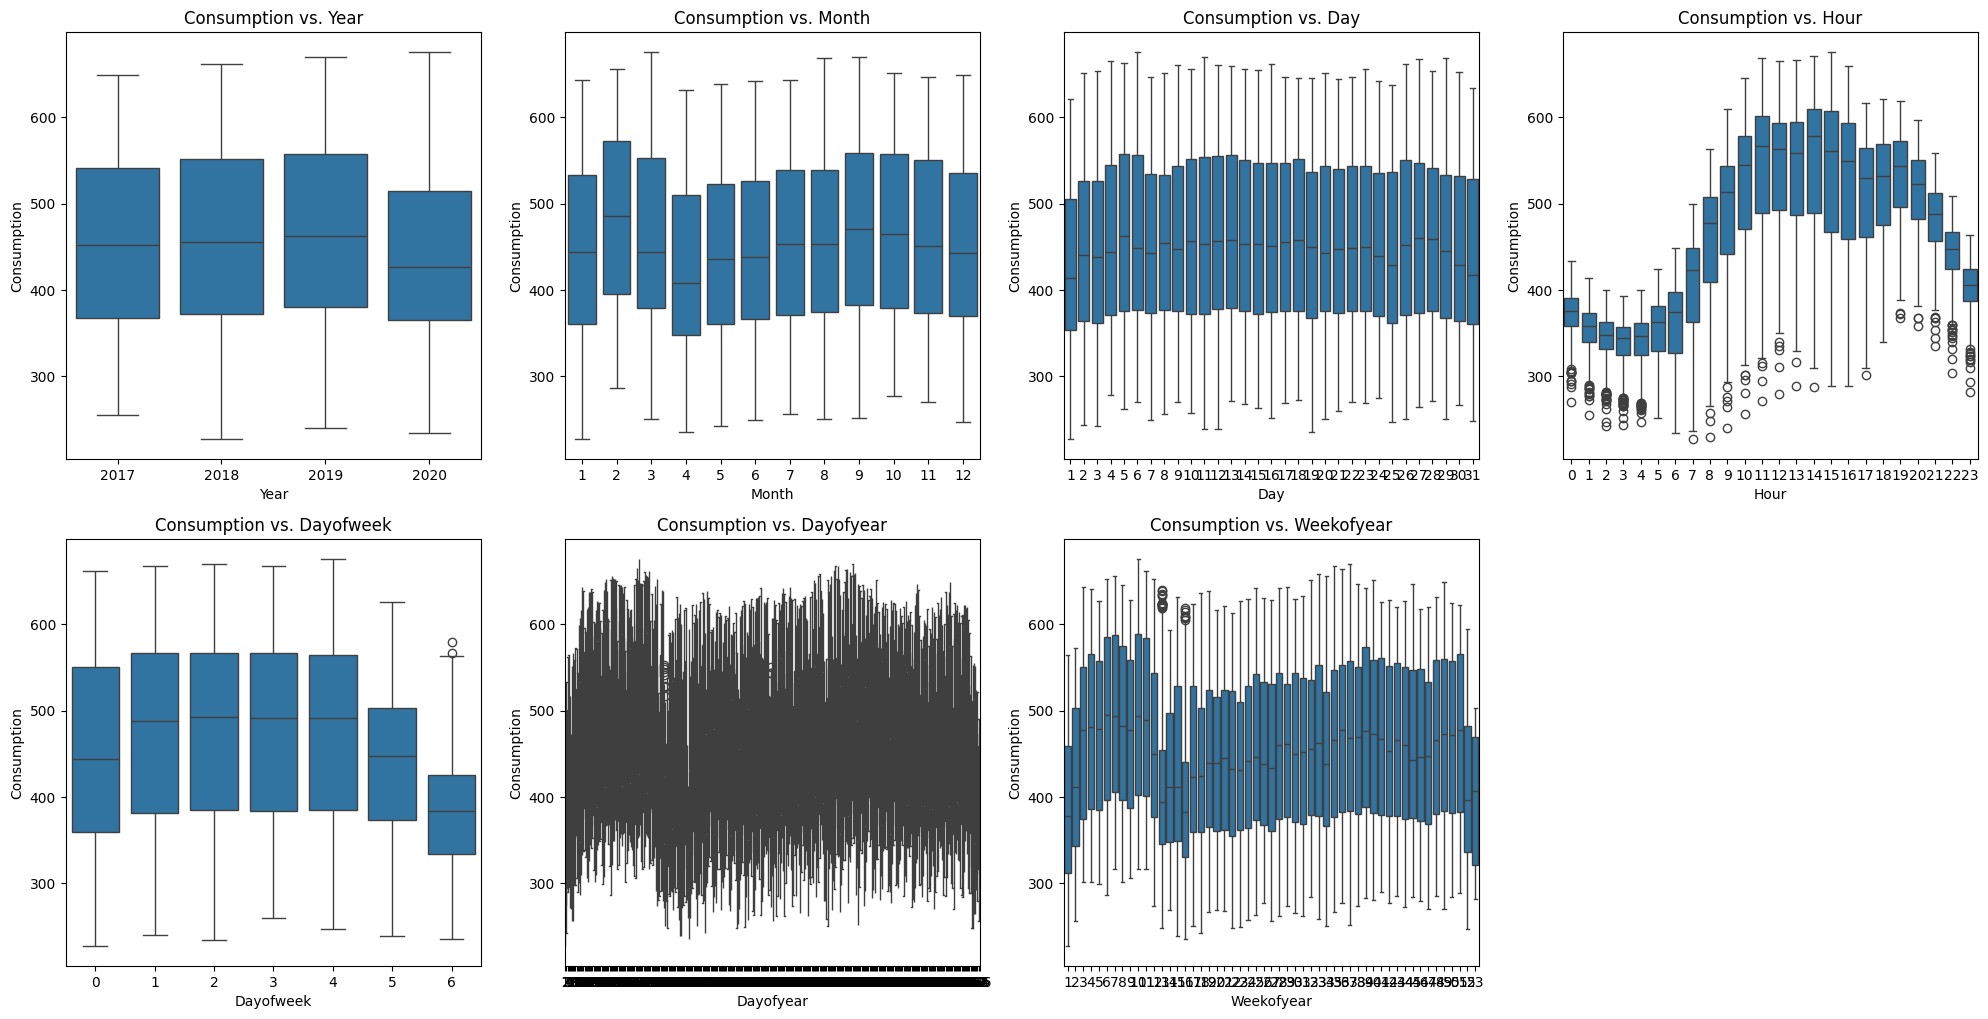

In [27]:
num_cols = 4
num_rows = (len(categorical_cols) * 2 + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.boxplot(x=col, y='Consumption', data=df, ax=axes[i])
    axes[i].set_title(f'Consumption vs. {col}')

    # Remove any unused subplots
for j in range(len(categorical_cols), num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- En la variable "Year" se puede evidenciar que los años 2020 y 2021 presentaron fenomenos sociales que impactaron directamente el consumo de eneriga en la ciudad de Cali. No existe en el dataset, una variable que permita modelar las restricciones a la movilidad en la pandemia y el paro nacional. *Se concidera prudente, sacar del estudio estos dos años.*
- Se puede observar de "Dayofweek" que el consumo en los dias 1 a 4 tiene un comportamiento similar, en cambio los días 0, 5 y 6 se diferencian de los otros dias de la semana.



### Analisis de outliers y datos Atipicos


#### Eliminar datos atipicos

Como se menciono antes, se procede a eliminar los datos de los años 2020 y 2021.

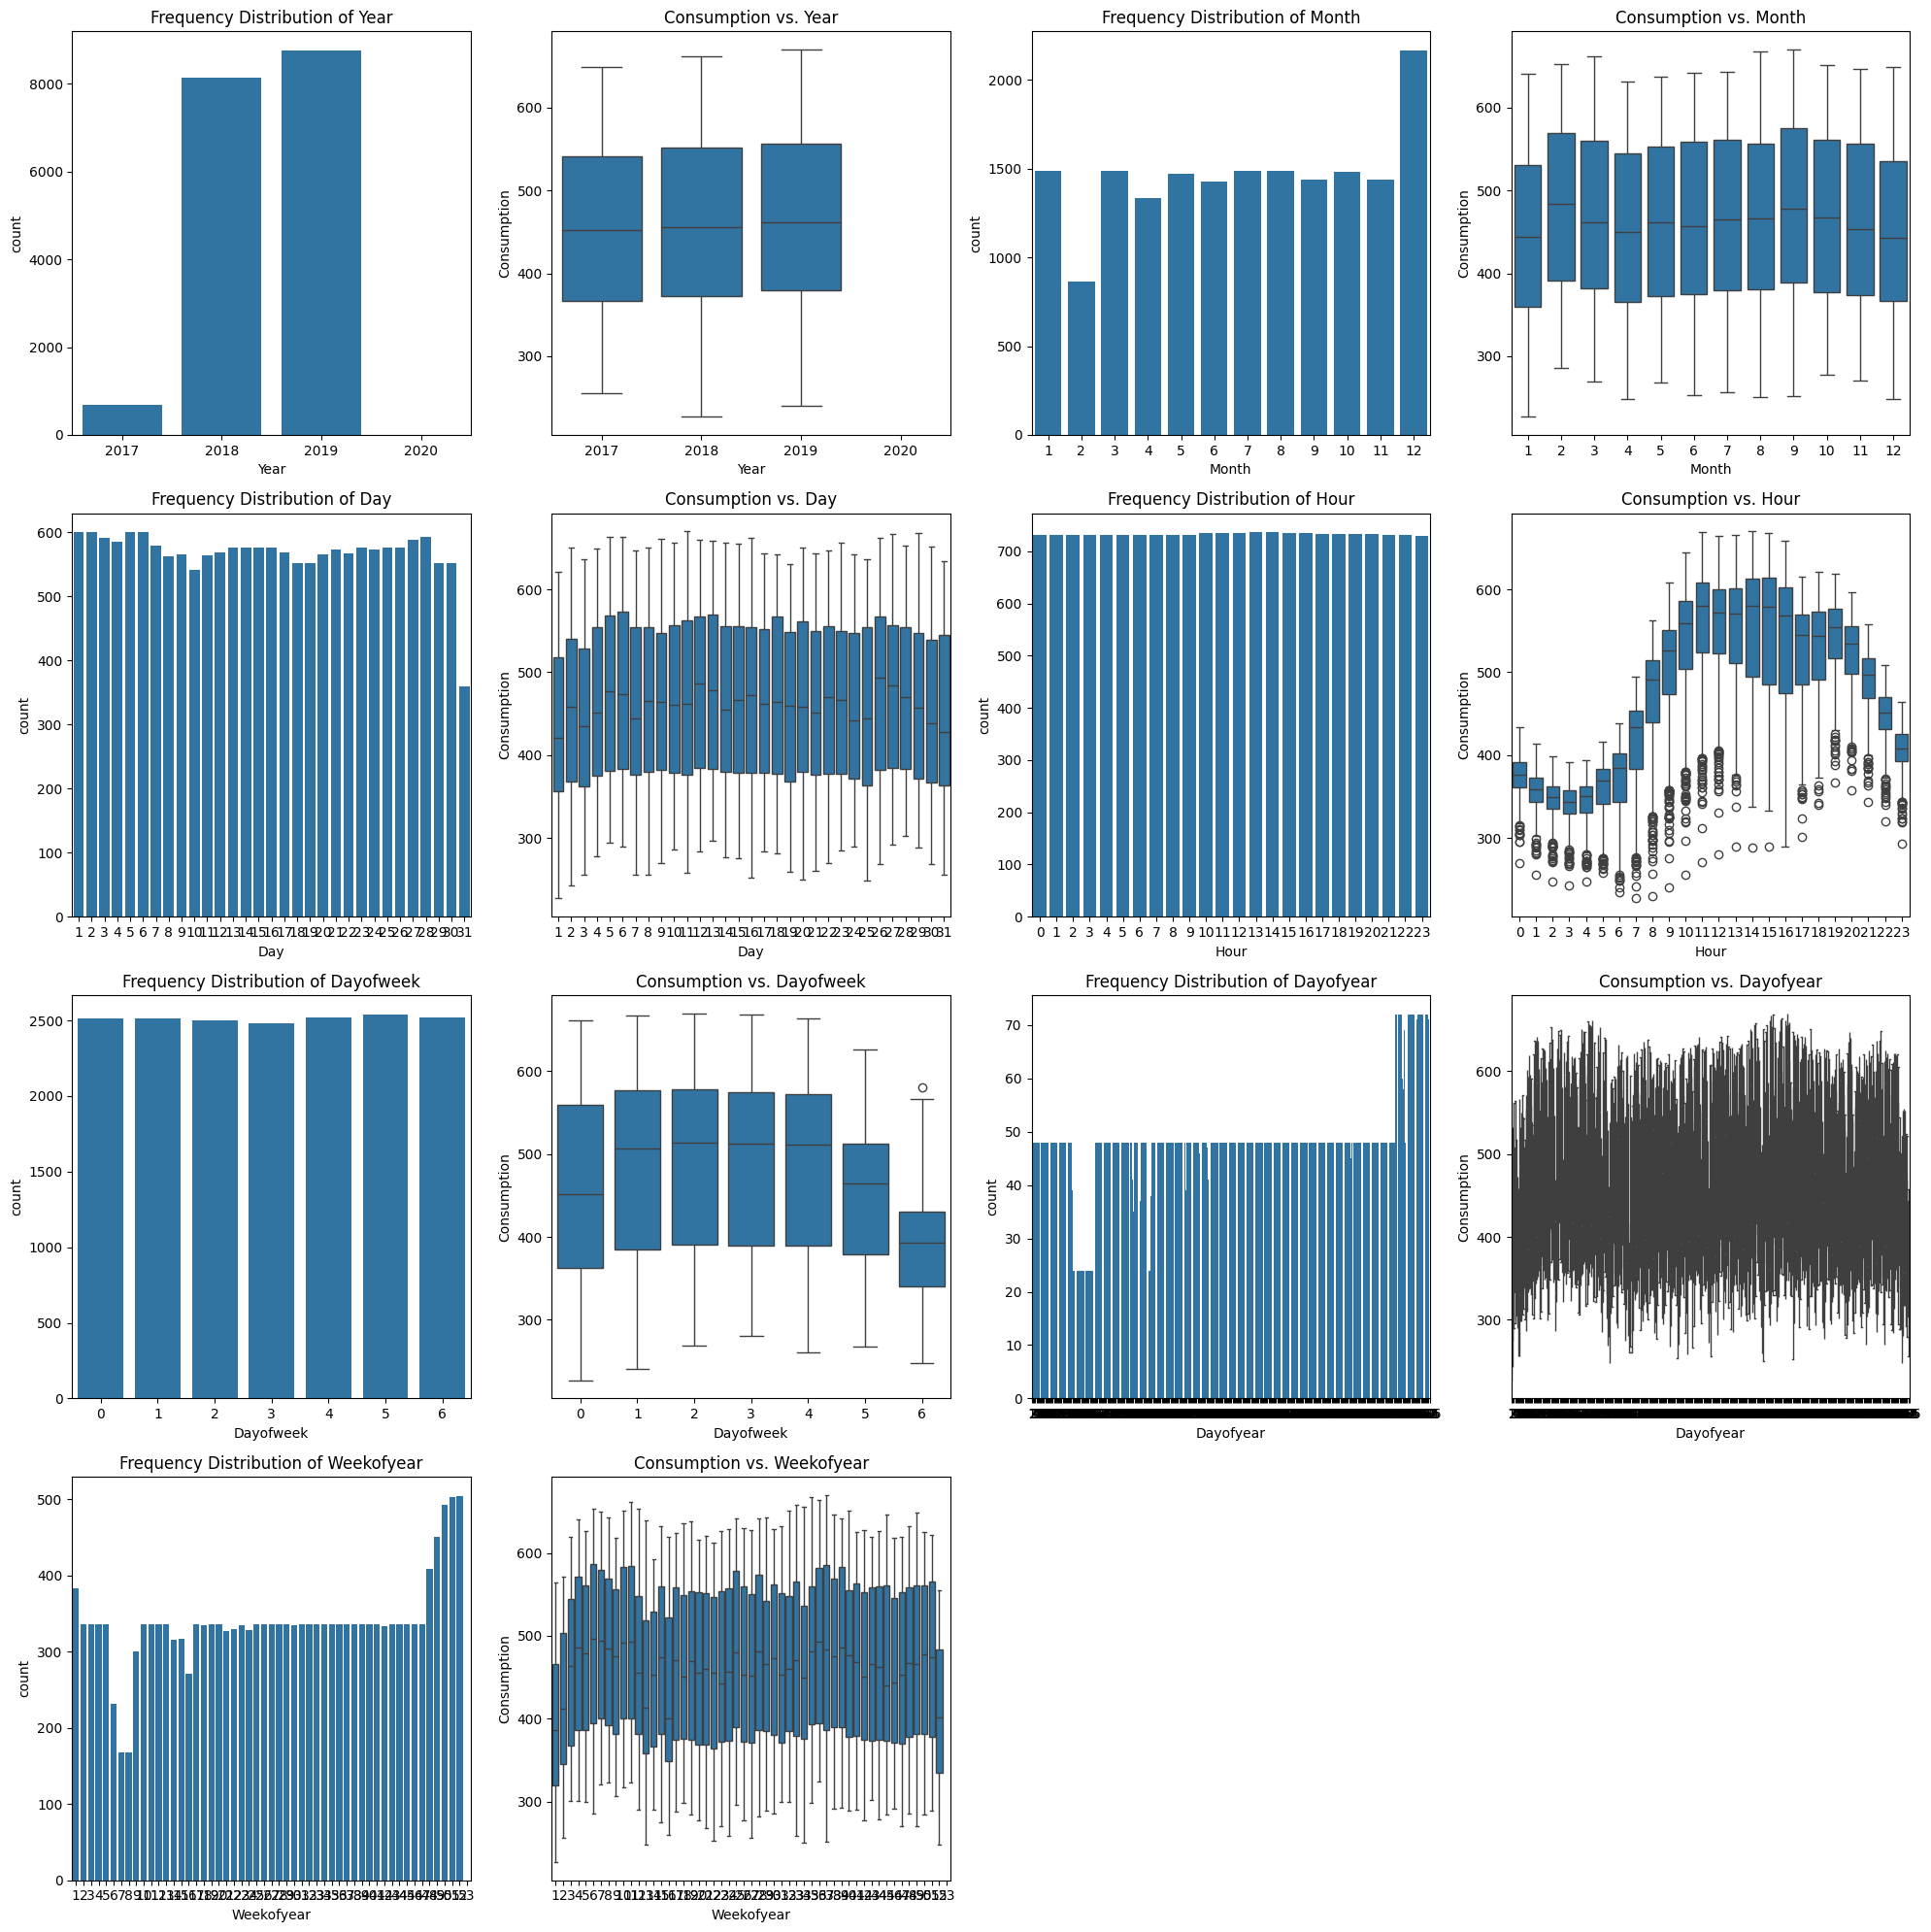

In [28]:
df = df.drop(df[(df['Year'] == 2020) | (df['Year'] == 2021)].index)
df = df.reset_index(drop=True)

num_cols = 4
num_rows = (len(categorical_cols) * 2 + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, data=df, ax=axes[i * 2])
    axes[i * 2].set_title(f'Frequency Distribution of {col}')
    sns.boxplot(x=col, y='Consumption', data=df, ax=axes[i * 2 + 1])
    axes[i * 2 + 1].set_title(f'Consumption vs. {col}')

for j in range(len(categorical_cols) * 2, num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust subplot parameters to give specified padding.
plt.show()

#### Analisis de Outliers

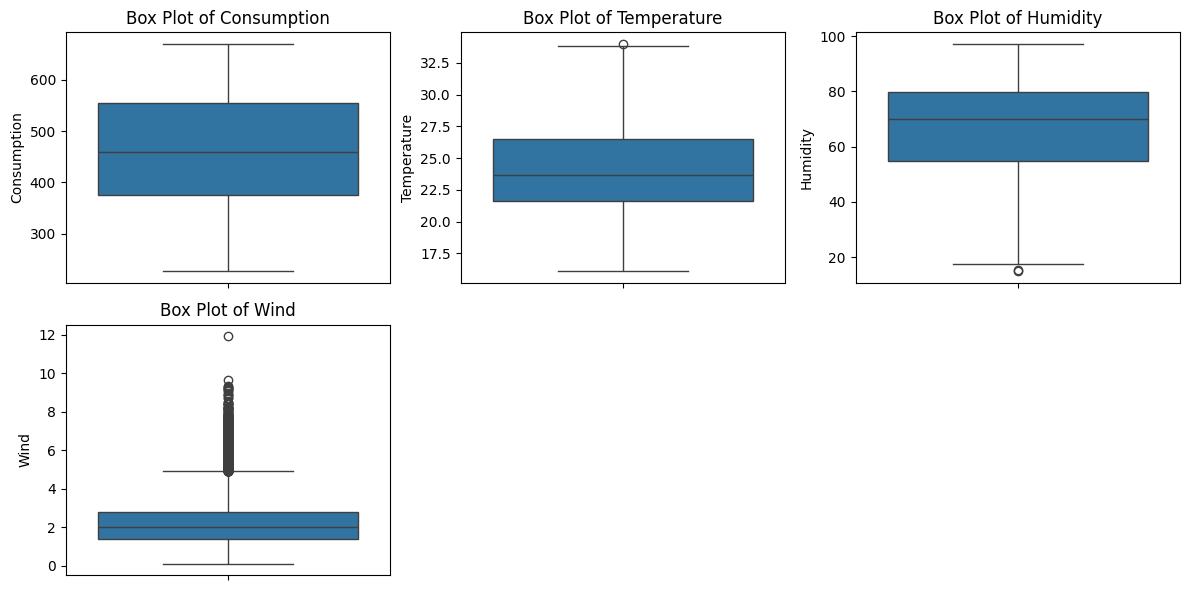


Analysis for numerical variable: Consumption
count    17584.000000
mean       464.446713
std         97.534335
min        227.000000
25%        376.000000
50%        459.000000
75%        554.000000
max        670.000000
Name: Consumption, dtype: float64
Number of outliers: 0
Lower bound: 109.0, Upper bound: 821.0


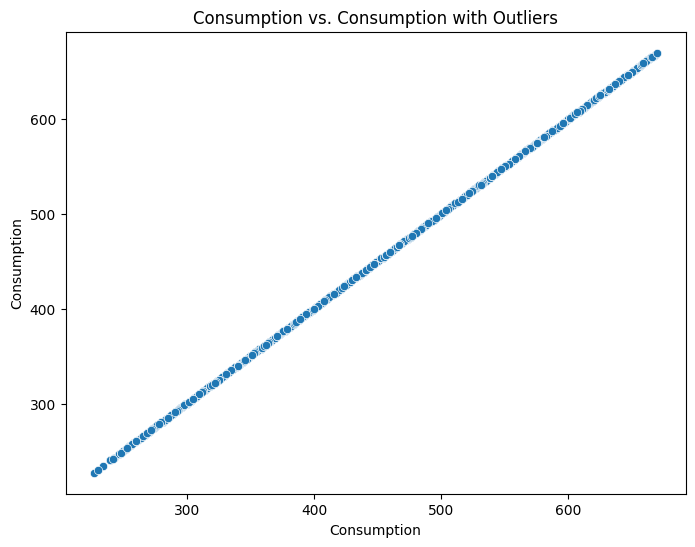


Analysis for numerical variable: Temperature
count    17584.000000
mean        24.152282
std          3.259889
min         16.100000
25%         21.600000
50%         23.700000
75%         26.500000
max         34.000000
Name: Temperature, dtype: float64
Number of outliers: 1
Lower bound: 14.250000000000004, Upper bound: 33.849999999999994


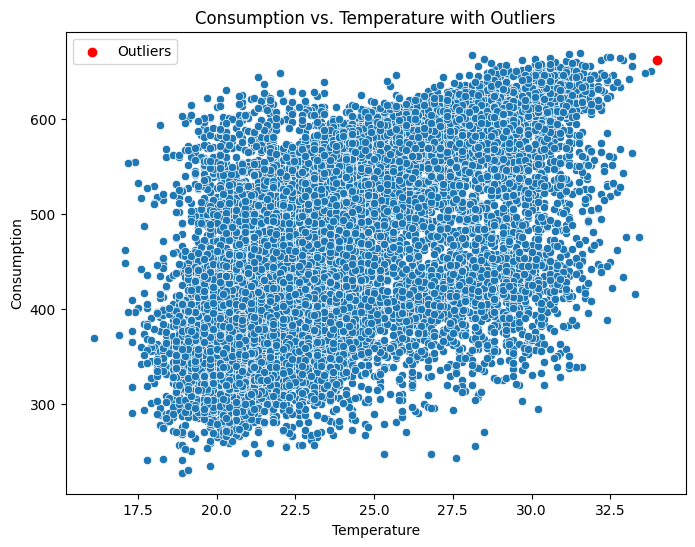


Analysis for numerical variable: Humidity
count    17584.000000
mean        67.405832
std         14.418633
min         14.850000
25%         54.866667
50%         69.900000
75%         79.933333
max         97.300000
Name: Humidity, dtype: float64
Number of outliers: 2
Lower bound: 17.26666666666666, Upper bound: 117.53333333333335


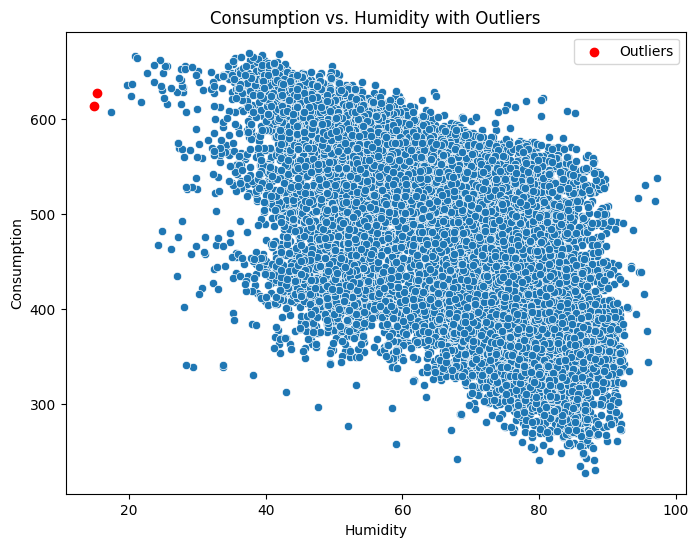


Analysis for numerical variable: Wind
count    17584.000000
mean         2.290743
std          1.257109
min          0.100000
25%          1.400000
50%          2.000000
75%          2.800000
max         11.933333
Name: Wind, dtype: float64
Number of outliers: 854
Lower bound: -0.6999999999999995, Upper bound: 4.8999999999999995


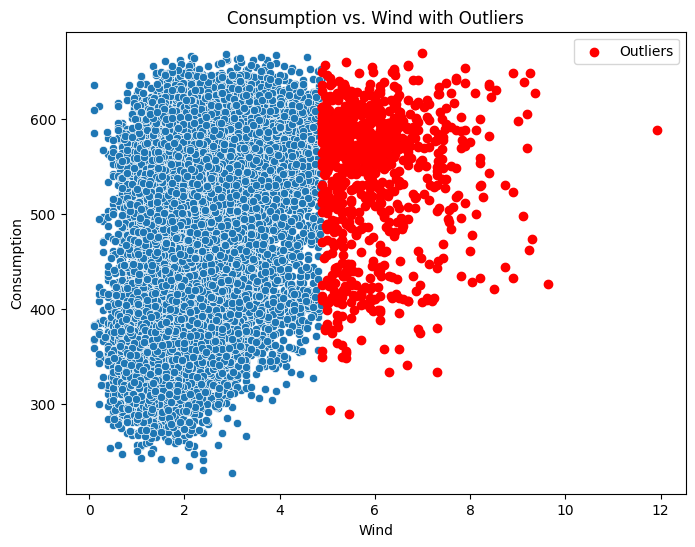

In [29]:
# Columnas numéricas
numerical_cols = ['Consumption', 'Temperature', 'Humidity', 'Wind']
# Box plots to visualize outliers
plt.figure(figsize=(12, 6))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

# Descriptive statistics and IQR outlier detection
for col in numerical_cols:
    print(f"\nAnalysis for numerical variable: {col}")
    print(df[col].describe())

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"Number of outliers: {len(outliers)}")
    print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=col, y='Consumption', data=df)
    plt.title(f'Consumption vs. {col} with Outliers')

    # Highlight outliers on the scatter plot
    if not outliers.empty:
        plt.scatter(outliers[col], outliers['Consumption'], color='red', label='Outliers')
        plt.legend()

    plt.show()

**Conclusiones Outliers**
- Se pudo observar un dato en la variable temperatura que se identificó como Outlier, sin embargo, este pudo obedecer a una temporada sin lluvia, en donde la temperatura se elevó a valores superiores.
- Para la variable Consumo, de acuerdo a lo manifestado por los expertos del negocio, los valores bajos se puden considedar como outliers, causados por apagones o fallas en la red de distribucion de energia.

In [30]:
df.isnull().sum()

Humidity            0
Wind                0
Consumption         0
Temperature         0
Is_holiday          0
Year                0
Month               0
Day                 0
Hour                0
Dayofweek           0
Dayofyear           0
Weekofyear          0
Is_month_end        0
Is_month_start      0
Is_quarter_end      0
Is_quarter_start    0
Is_year_end         0
Is_year_start       0
dtype: int64

# 4  Imputación de datos


In [32]:
# Create a copy of the DataFrame to avoid SettingWithCopyWarning
df_cleaned = df.copy()

# Crea series desplazadas para el valor anterior y siguiente
temperatura_anterior = df_cleaned['Temperature'].shift(1)
temperatura_siguiente = df_cleaned['Temperature'].shift(-1)

# Calcula el promedio del valor anterior y siguiente
promedio_anterior_siguiente = (temperatura_anterior + temperatura_siguiente) / 2

# Imputa los valores faltantes con el promedio
df_cleaned['Temperature'] = df_cleaned['Temperature'].fillna(promedio_anterior_siguiente)

# Manejar los valores NaN restantes al inicio o al final del DataFrame
df_cleaned['Temperature'] = df_cleaned['Temperature'].fillna(df_cleaned['Temperature'].median()) # Corregido

# Reassign the cleaned DataFrame to df
df = df_cleaned

print(df.head())
print(df.info())
print(df.isnull().sum())

   Humidity  Wind  Consumption  Temperature  Is_holiday  Year Month Day Hour  \
0     72.55   2.6        409.0         27.9       False  2017    12   1    0   
1     73.40   3.1        387.0         29.0       False  2017    12   1    1   
2     75.65   2.4        378.0         29.1       False  2017    12   1    2   
3     78.35   2.3        370.0         28.2       False  2017    12   1    3   
4     80.00   1.0        364.0         26.7       False  2017    12   1    4   

  Dayofweek Dayofyear Weekofyear  Is_month_end  Is_month_start  \
0         4       335         48         False            True   
1         4       335         48         False            True   
2         4       335         48         False            True   
3         4       335         48         False            True   
4         4       335         48         False            True   

   Is_quarter_end  Is_quarter_start  Is_year_end  Is_year_start  
0           False             False        False        

- En el dataset estudiado no hay presencia de datos faltantes, se contempla el proceso de imputacion para la variable **Temperatura** debido a la posibilidad de la llegada de nuevos datos, a travez del cual se puede imputar los valores nulos.
- Para imputar se tiene en cuenta la medida anterior y posterior con referencia al dato nulo, se realiza un promedio de estas dos medidas, teniendo en cuenta el vector.

## 4.1  Division de datasets


In [33]:
y = df['Consumption']
X = df.drop(['Consumption'], axis=1)

print("primeras filas \n")
print(X.head())

print("se describen las columnas \n")
print(X.info())

print("dimensiones \n")
print(X.shape)
print("dimensiones \n")
print(y.shape)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


primeras filas 

   Humidity  Wind  Temperature  Is_holiday  Year Month Day Hour Dayofweek  \
0     72.55   2.6         27.9       False  2017    12   1    0         4   
1     73.40   3.1         29.0       False  2017    12   1    1         4   
2     75.65   2.4         29.1       False  2017    12   1    2         4   
3     78.35   2.3         28.2       False  2017    12   1    3         4   
4     80.00   1.0         26.7       False  2017    12   1    4         4   

  Dayofyear Weekofyear  Is_month_end  Is_month_start  Is_quarter_end  \
0       335         48         False            True           False   
1       335         48         False            True           False   
2       335         48         False            True           False   
3       335         48         False            True           False   
4       335         48         False            True           False   

   Is_quarter_start  Is_year_end  Is_year_start  
0             False        False     

## 4.2  Estandarización y Escalamiento


Teniendo en cuenta que solo la variable temperatura es numerica y continua no se requiere Escalar o normalizar.

In [34]:
# from sklearn.preprocessing import StandardScaler


# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)


# 5  Feature Engineering


## 5.1  Codificar Variables Categoricas


Como las variables categoricas del dataset no tienen una cardinalidad, se usa la codificación One Hot Encoding, para su aplicación en el modelo.

In [35]:
# Use pd.get_dummies with the 'columns' parameter to specify which columns to dummify
X_train = pd.get_dummies(X_train, columns=categorical_cols)
X_test = pd.get_dummies(X_test, columns=categorical_cols)
#print(X_train.head())

# Check if the number of columns in X_train and X_test are equal
print(f"Number of columns in X_train: {X_train.shape[1]} \n")
print(f"Number of columns in X_test: {X_test.shape[1]}")


Number of columns in X_train: 507 

Number of columns in X_test: 507


## 5.2  PCA


## 5.3  LDA


## 5.4  Clustering


No aplica, Colocar Explicacion

# 6 Regularización

In [36]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso


Prueba de Ridge

In [37]:
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)

# Coeficientes de Ridge
print('Intercepto: ', ridge.intercept_)
print('Coeficientes: ', ridge.coef_)
print('R2 Test: ', ridge.score(X_test, y_test))
print('R2 Train: ', ridge.score(X_train, y_train))

Intercepto:  505.55290685718603
Coeficientes:  [-1.06679217e+00  1.03702306e+00  1.44155531e+00 -8.80690393e+01
 -5.58093167e-01  2.11873929e-02 -1.48995233e+01 -3.17728269e+01
 -4.53932665e+00 -2.15666969e+00  2.52335084e+00 -4.36388556e+00
  1.84053472e+00  0.00000000e+00  6.39081264e+00  2.88534810e+00
  1.80115833e+01 -3.07018656e-01 -2.24557521e+01 -5.21023240e+01
  2.01504484e+01  8.00311458e+01  5.49376408e+00 -2.16600246e+01
 -1.39246154e+01 -2.25133676e+01  2.11873929e-02 -1.57908019e+00
 -8.79400991e+00  2.29943447e+00  5.78900322e+00  6.51790680e+00
  7.83514760e+00  1.36566326e+01  2.04414197e+00 -5.49556495e-01
 -4.31454023e-01  3.77161995e+00  6.32796318e+00  3.15495997e+00
  3.23466457e+00 -3.23853475e+00 -2.84985294e+00 -5.33518273e+00
 -1.14830528e+01 -6.42080004e+00 -1.55356553e+01 -5.19611028e+00
 -4.14250785e+00 -1.39328037e+00  1.94602275e+00  2.92314327e+00
  1.90276994e+00  2.19479695e+00  3.28146430e+00 -1.05645027e+00
  1.10466901e+00 -7.59763927e+01 -9.0981215

Prueba Lasso

In [38]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

# Coeficientes de Lasso
print('Intercepto: ', lasso.intercept_)
print('Coeficientes: ', lasso.coef_)
print('R2 Test: ', lasso.score(X_test, y_test))
print('R2 Train: ', lasso.score(X_train, y_train))

Intercepto:  588.6600840556804
Coeficientes:  [-1.70881296e+00  2.04109151e+00  2.07994451e+00 -8.69848143e+01
 -2.91633011e-01 -4.08035126e+00 -7.81748366e+00 -4.98115381e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -5.68622346e+00
  0.00000000e+00  0.00000000e+00 -1.51109862e-02  4.81965410e+00
  2.19967106e+00 -0.00000000e+00  2.70473991e+00 -4.12172801e-01
 -9.11237489e-01 -1.12333778e+01  1.41245664e+00  0.00000000e+00
  1.39822259e+00 -0.00000000e+00 -4.51699574e+00 -2.74664711e+00
 -7.18510619e+00 -0.00000000e+00  4.70765640e-01  2.24562320e+00
  3.41522165e+00  8.61456495e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  8.67226262e-01  4.12287615e+00  8.65124499e-01
  0.00000000e+00 -7.58736053e-01 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -5.83319300e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  7.72913748e-02  1.78563059e+00  2.94467518e+00 -0.00000000e+00
 -4.52389014e+00 -9.79421847e+01 -1.11914377

# 7 Data Pipeline


In [39]:
# scoring data
from sklearn.metrics import accuracy_score

# importing pipes for making the Pipe flow
from sklearn.pipeline import Pipeline

#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


pipe = Pipeline([
  ('Estandarizacion', StandardScaler()),
  ('model', RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),)
],verbose = True)

pipe.fit(X_train, y_train)

# y_pred = pipe.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
#print("Accuracy:", accuracy_score(y_test, pipe.predict(X_test)))

[Pipeline] ... (step 1 of 2) Processing Estandarizacion, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   8.6s


Pipeline(steps=[('Estandarizacion', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=10, random_state=42))],
         verbose=True)

# 7  Modelamiento

## Modelo hibrido XGBoost + DNN

In [40]:
import xgboost as xgb
from tensorflow import keras

# 1. Define and train the DNN model
dnn_model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)  # Output layer for regression
])

dnn_model.compile(optimizer='adam', loss='mse')
dnn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)
 
# 2. Use the DNN model to generate predictions for the training and test sets
dnn_train_predictions = dnn_model.predict(X_train)
dnn_test_predictions = dnn_model.predict(X_test)

# 3. Combine the original features with the DNN predictions
X_train_hybrid = np.hstack((X_train, dnn_train_predictions))
X_test_hybrid = np.hstack((X_test, dnn_test_predictions))

# 4. Train the XGBoost model using the hybrid features
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=10, random_state=42)
xgb_model.fit(X_train_hybrid, y_train)

# 5. Make predictions with the XGBoost model
y_pred_hybrid = xgb_model.predict(X_test_hybrid)

# 6. Evaluate the hybrid model
mse_hybrid = mean_squared_error(y_test, y_pred_hybrid)
r2_hybrid = r2_score(y_test, y_pred_hybrid)
mae_hybrid = mean_absolute_error(y_test, y_pred_hybrid)
rmse_hybrid = np.sqrt(mse_hybrid)

print(f"Hybrid Model - Mean Squared Error (MSE): {mse_hybrid}")
print(f"Hybrid Model - R-squared (R2): {r2_hybrid}")
print(f"Hybrid Model - Mean Absolute Error (MAE): {mae_hybrid}")
print(f"Hybrid Model - Root Mean Squared Error (RMSE): {rmse_hybrid}")

c:\Users\rchic\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 27306.2012 - val_loss: 9903.0762
Epoch 2/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10859.6240 - val_loss: 5702.9746
Epoch 3/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7729.4683 - val_loss: 7445.4790
Epoch 4/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7438.9873 - val_loss: 4821.5918
Epoch 5/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7160.4751 - val_loss: 5520.9907
Epoch 6/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6689.2202 - val_loss: 3607.1499
Epoch 7/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6675.6514 - val_loss: 3600.8284
Epoch 8/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6646.5264 - val_loss: 3463.1079
Epoch 9/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6356.8901 - val_loss: 3479.1677
Epoch 10/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6118.7856 - val_loss: 3307.2832
Epoch 11/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6542.

RegresionLineal

In [42]:
# Initialize the Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

# Calculate MAE and MedAE
mae = mean_absolute_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Median Absolute Error (MedAE): {medae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Squared Error (MSE): 3151.4676546246474
R-squared (R2): 0.6742983389472124
Mean Absolute Error (MAE): 44.955600108879736
Median Absolute Error (MedAE): 38.77469004201885
Root Mean Squared Error (RMSE): 56.13793418558121


Randomforest

In [43]:
# Initialize the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print the evaluation metrics
print(f"Random Forest - Mean Squared Error (MSE): {mse_rf}")
print(f"Random Forest - R-squared (R2): {r2_rf}")

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred_rf)

# Calculate the Median Absolute Error (MedAE)
medae = median_absolute_error(y_test, y_pred_rf)

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

# Print the calculated MAE, MedAE, and RMSE values.
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Median Absolute Error (MedAE): {medae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Random Forest - Mean Squared Error (MSE): 553.8757022244835
Random Forest - R-squared (R2): 0.9427573892543156
Mean Absolute Error (MAE): 16.220293150540098
Median Absolute Error (MedAE): 12.190206017854848
Root Mean Squared Error (RMSE): 23.534563990532806


Red neuronal

Epoch 1/100


c:\Users\rchic\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 38549.8594 - val_loss: 12191.9033
Epoch 2/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 12215.0254 - val_loss: 6052.2383
Epoch 3/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9040.2705 - val_loss: 6523.7861
Epoch 4/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7711.7949 - val_loss: 4763.0269
Epoch 5/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7112.1436 - val_loss: 3963.2119
Epoch 6/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6995.7729 - val_loss: 4767.5200
Epoch 7/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6782.0151 - val_loss: 4291.2349
Epoch 8/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6460.7764 - val_loss: 3718.3142
Epoch 9/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6356.9800 - val_loss: 3577.2434
Epoch 10/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6417.0767 - val_loss: 5137.7329
Epoch 11/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6387.0732 - val_

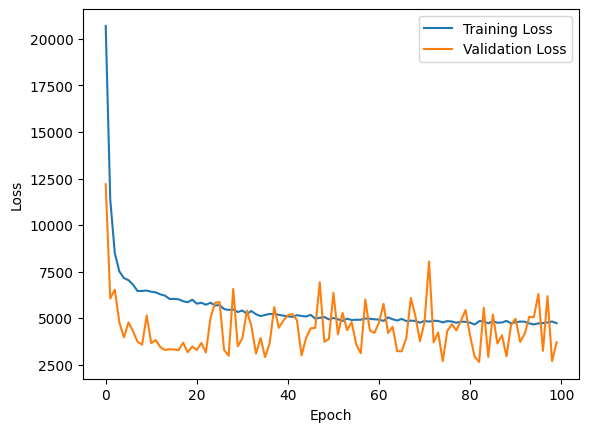

In [44]:
# 1. Definir el modelo de la red neuronal
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)  # Capa de salida para regresión
])

# 2. Compilar el modelo
model.compile(optimizer='adam', loss='mse')  # Usamos 'mse' (error cuadrático medio) para regresión

# 3. Entrenar el modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# 4. Realizar predicciones
y_pred = model.predict(X_test)

# 5. Calcular métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

# Opcional: Graficar la pérdida durante el entrenamiento
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Red neuronal con LSTM

In [ ]:
df.head()
